# Statistical Mapping of the National Social Assistance Programme

### Key Technologies :
### Data Processing: PySpark, Pandas
### Visualization: Matplotlib, Seaborn
### Data Source: National Social Assistance Programme (NSAP) Dataset – 2024

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, corr, sum as _sum, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("NationalSocialAssistanceProgrammeAnalysis").getOrCreate()

In [3]:
df = spark.read.csv("National_social_assistance_programme.csv", header=True, inferSchema=True)
print(df.count(), len(df.columns))
df.printSchema()
df.show(5)

8694 15
root
 |-- fin_year: string (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- lgd_state_code: integer (nullable = true)
 |-- state_name: string (nullable = true)
 |-- lgd_district_code: integer (nullable = true)
 |-- district_name: string (nullable = true)
 |-- scheme_code: string (nullable = true)
 |-- total_beneficiaries: integer (nullable = true)
 |-- total_sc: integer (nullable = true)
 |-- total_st: integer (nullable = true)
 |-- total_gen: integer (nullable = true)
 |-- total_obc: integer (nullable = true)
 |-- total_aadhar: integer (nullable = true)
 |-- total_mobileno: integer (nullable = true)
 |-- lastUpdated: date (nullable = true)

+---------+----+--------------+-----------------+-----------------+-------------+-----------+-------------------+--------+--------+---------+---------+------------+--------------+-----------+
| fin_year|mnth|lgd_state_code|       state_name|lgd_district_code|district_name|scheme_code|total_beneficiaries|total_sc|total_st|total_ge

In [4]:
df.describe().show()

+-------+---------+------------------+-----------------+-------------------+------------------+-----------------+-----------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary| fin_year|              mnth|   lgd_state_code|         state_name| lgd_district_code|    district_name|scheme_code|total_beneficiaries|          total_sc|          total_st|         total_gen|         total_obc|      total_aadhar|   total_mobileno|
+-------+---------+------------------+-----------------+-------------------+------------------+-----------------+-----------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|     8694|              8694|             8694|               8694|              8694|             8694|       8694|               8694|              8694|              8694|              8694|              8694|  

In [5]:
numeric_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ["double", "float"]]
exprs = [count(when(col(c).isNull() | (isnan(col(c)) if c in numeric_cols else False),c)).alias(c)for c in df.columns]
df.select(exprs).show()

+--------+----+--------------+----------+-----------------+-------------+-----------+-------------------+--------+--------+---------+---------+------------+--------------+-----------+
|fin_year|mnth|lgd_state_code|state_name|lgd_district_code|district_name|scheme_code|total_beneficiaries|total_sc|total_st|total_gen|total_obc|total_aadhar|total_mobileno|lastUpdated|
+--------+----+--------------+----------+-----------------+-------------+-----------+-------------------+--------+--------+---------+---------+------------+--------------+-----------+
|       0|   0|             0|         0|                0|            0|          0|                  0|       0|       0|        0|        0|           0|             0|          0|
+--------+----+--------------+----------+-----------------+-------------+-----------+-------------------+--------+--------+---------+---------+------------+--------------+-----------+



In [6]:
df_pd = df.toPandas()

In [7]:
C_STATE = "state_name"
C_DISTRICT = "district_name"
C_BENEF = "total_beneficiaries"
C_SC = "total_sc"
C_ST = "total_st"
C_GEN = "total_gen"
C_OBC = "total_obc"

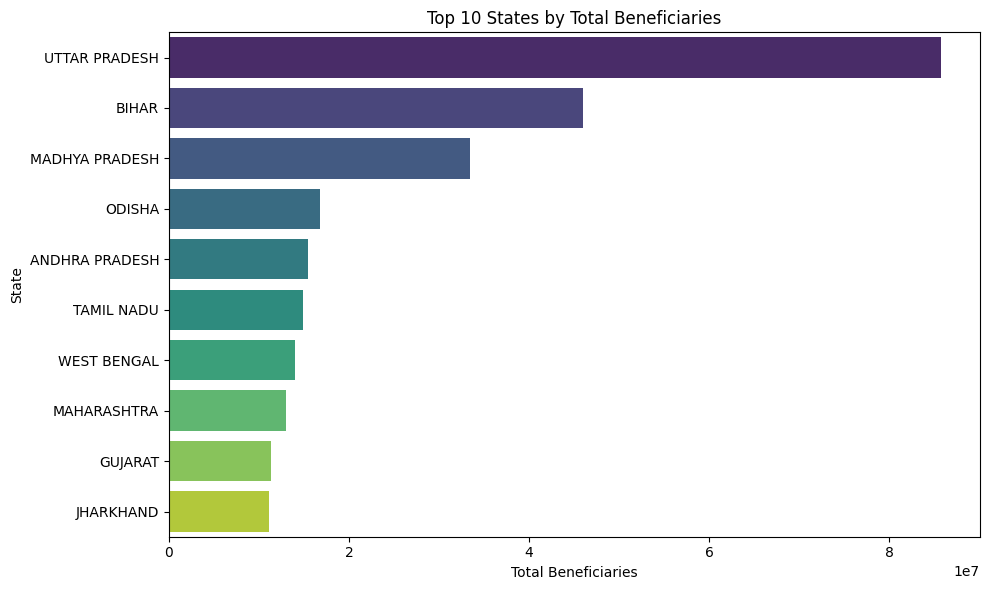

📊 Observation:
- The bar chart ranks the top 10 states by total beneficiaries, with the x-axis showing total beneficiaries and the y-axis listing states.
- A few states dominate the chart, indicating concentrated program reach in those states.
- Use this to prioritise outreach or resources for lower-ranked states to balance coverage.


In [8]:
top_states = df.groupBy(C_STATE).agg(_sum(C_BENEF).alias("Total_Beneficiaries")).orderBy(col("Total_Beneficiaries").desc())
top_states_pd = top_states.limit(10).toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y=C_STATE, x="Total_Beneficiaries", data=top_states_pd, hue=C_STATE, palette="viridis", dodge=False, legend=False)
plt.title("Top 10 States by Total Beneficiaries")
plt.xlabel("Total Beneficiaries")
plt.ylabel("State")
plt.tight_layout()
plt.show()
print("📊 Observation:")
print("- The bar chart ranks the top 10 states by total beneficiaries, with the x-axis showing total beneficiaries and the y-axis listing states.")
print("- A few states dominate the chart, indicating concentrated program reach in those states.")
print("- Use this to prioritise outreach or resources for lower-ranked states to balance coverage.")

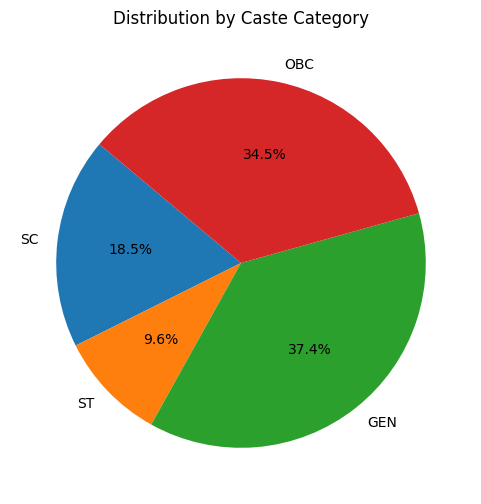

📊 Observation:
- The pie chart shows the proportional share of beneficiaries across caste categories (SC, ST, OBC, GEN).
- It reveals which social groups hold the largest and smallest shares, indicating relative inclusiveness.
- If any group appears under-represented, consider targeted awareness or eligibility adjustments.


In [9]:
caste_sum = df.select(_sum(C_SC).alias("SC"), _sum(C_ST).alias("ST"), _sum(C_GEN).alias("GEN"), _sum(C_OBC).alias("OBC")).toPandas().T
caste_sum.columns = ["Total"]
caste_sum["Category"] = caste_sum.index
plt.figure(figsize=(6,6))
plt.pie(caste_sum["Total"], labels=caste_sum["Category"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution by Caste Category")
plt.show()
print("📊 Observation:")
print("- The pie chart shows the proportional share of beneficiaries across caste categories (SC, ST, OBC, GEN).")
print("- It reveals which social groups hold the largest and smallest shares, indicating relative inclusiveness.")
print("- If any group appears under-represented, consider targeted awareness or eligibility adjustments.")

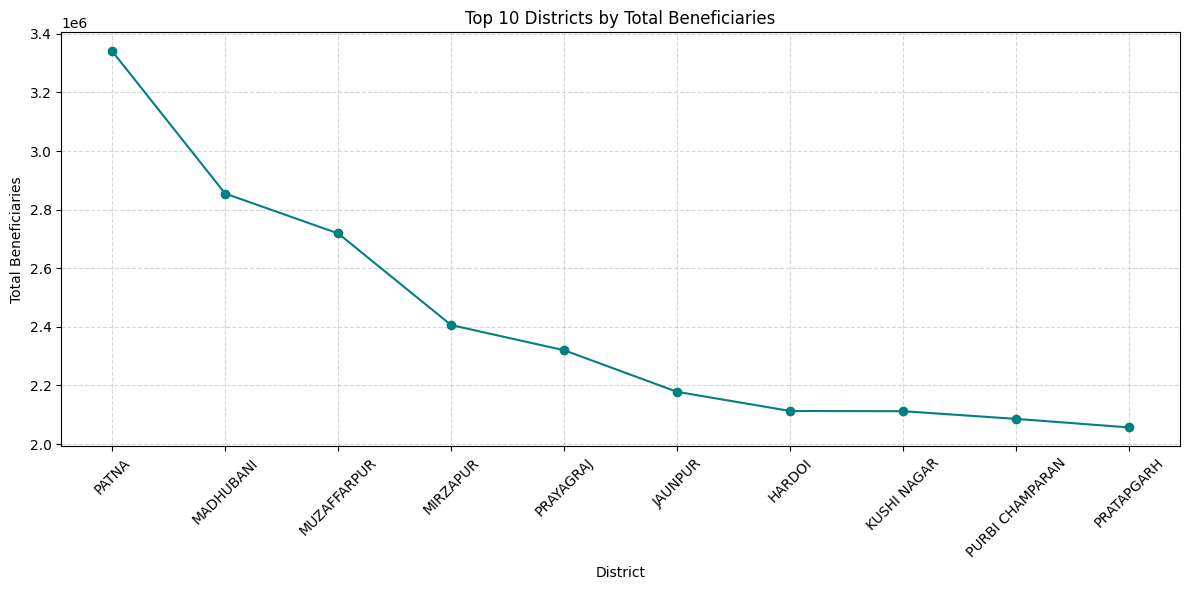

📊 Observation:
- The plot lists the top 10 districts by total beneficiaries, highlighting district-level concentration.
- A sharp drop after the top few districts suggests uneven distribution at the district level.
- Identifying these high- and low-performing districts can guide geographically targeted interventions.


In [10]:
top_districts = df.groupBy(C_DISTRICT)\
                  .agg(_sum(C_BENEF).alias("Total_Beneficiaries"))\
                  .orderBy(col("Total_Beneficiaries").desc())\
                  .limit(10)
top_districts_pd = top_districts.toPandas()
plt.figure(figsize=(12,6))
plt.plot(top_districts_pd[C_DISTRICT], top_districts_pd["Total_Beneficiaries"], marker='o', linestyle='-', color='teal')
plt.xticks(rotation=45)
plt.title("Top 10 Districts by Total Beneficiaries")
plt.xlabel("District")
plt.ylabel("Total Beneficiaries")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print("📊 Observation:")
print("- The plot lists the top 10 districts by total beneficiaries, highlighting district-level concentration.")
print("- A sharp drop after the top few districts suggests uneven distribution at the district level.")
print("- Identifying these high- and low-performing districts can guide geographically targeted interventions.")

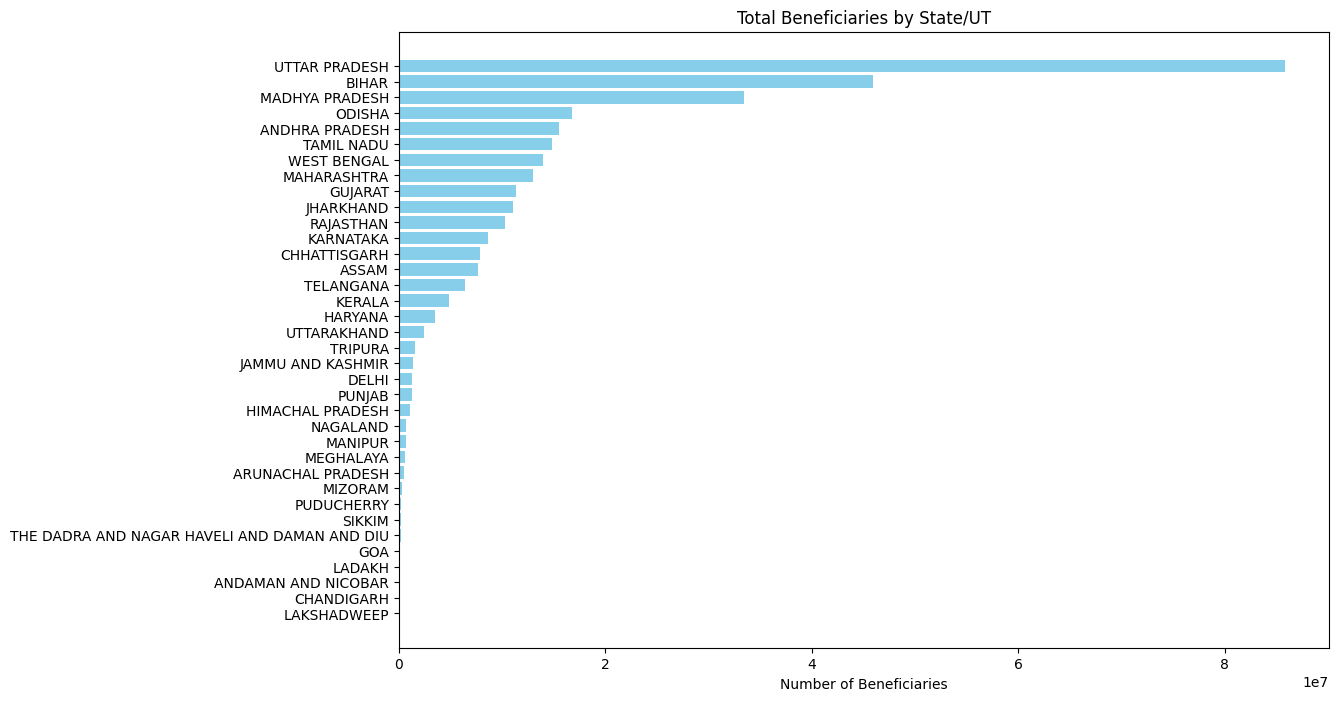

📊 Observation:
- This bar chart compares total beneficiaries across all States/UTs, showing absolute counts per State/UT.
- Large differences between bars point to uneven program penetration or population differences.
- Investigate whether variation is due to population, program rollout, or data coverage gaps.


In [11]:
state_beneficiaries = df.groupBy("state_name").sum("total_beneficiaries").toPandas()
state_beneficiaries = state_beneficiaries.sort_values("sum(total_beneficiaries)", ascending=True)

plt.figure(figsize=(12,8))
plt.barh(state_beneficiaries["state_name"], state_beneficiaries["sum(total_beneficiaries)"], color="skyblue")
plt.title("Total Beneficiaries by State/UT")
plt.xlabel("Number of Beneficiaries")
plt.show()
print("📊 Observation:")
print("- This bar chart compares total beneficiaries across all States/UTs, showing absolute counts per State/UT.")
print("- Large differences between bars point to uneven program penetration or population differences.")
print("- Investigate whether variation is due to population, program rollout, or data coverage gaps.")

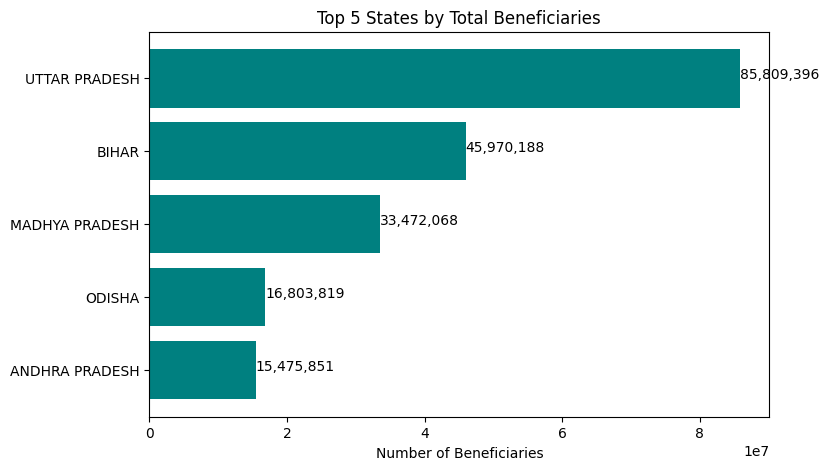

📊 Observation:
- The bar chart highlights the top 5 states by beneficiary count, focusing attention on the largest contributors.
- These few states account for a substantial share of beneficiaries, indicating concentrated impact.
- Consider studying their implementation practices as possible best-practices to scale elsewhere.


In [12]:
top5_beneficiaries = df.groupBy("state_name").sum("total_beneficiaries").toPandas()
top5_beneficiaries = top5_beneficiaries.sort_values("sum(total_beneficiaries)", ascending=False).head(5)

plt.figure(figsize=(8,5))
plt.barh(top5_beneficiaries["state_name"], top5_beneficiaries["sum(total_beneficiaries)"], color="teal")
for index, value in enumerate(top5_beneficiaries["sum(total_beneficiaries)"]):
    plt.text(value + 5000, index, f"{int(value):,}")
plt.title("Top 5 States by Total Beneficiaries")
plt.xlabel("Number of Beneficiaries")
plt.gca().invert_yaxis()
plt.show()
print("📊 Observation:")
print("- The bar chart highlights the top 5 states by beneficiary count, focusing attention on the largest contributors.")
print("- These few states account for a substantial share of beneficiaries, indicating concentrated impact.")
print("- Consider studying their implementation practices as possible best-practices to scale elsewhere.")

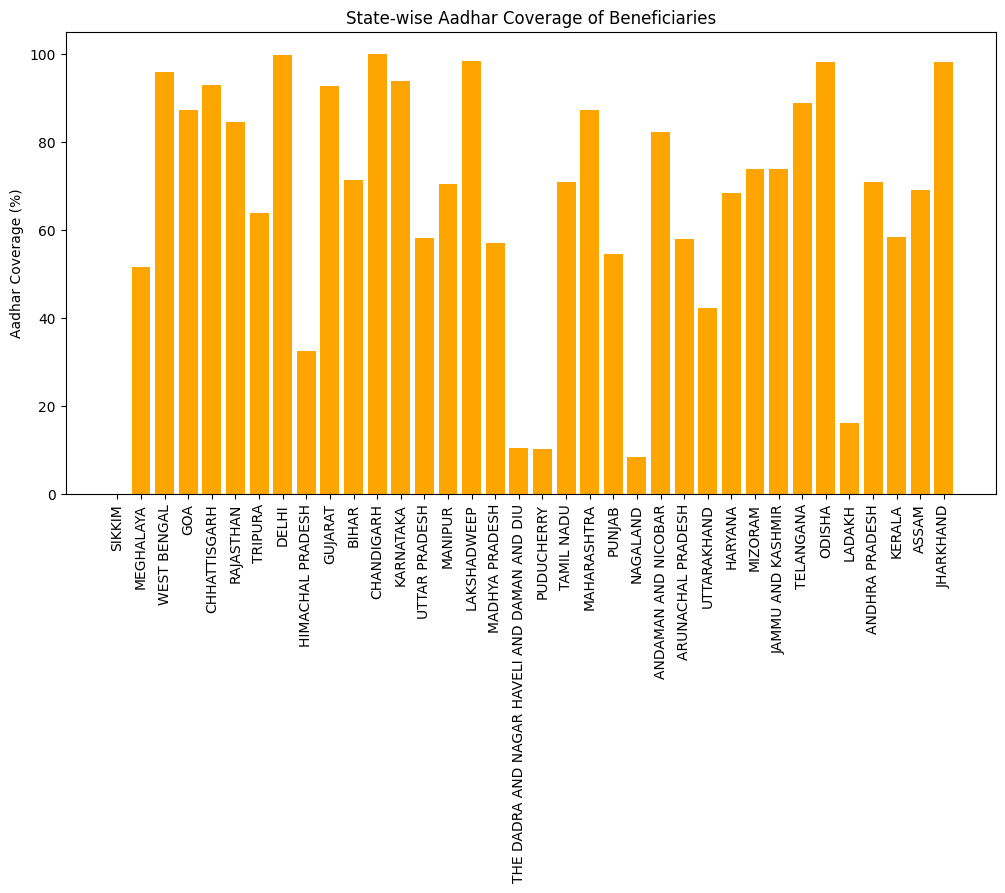

📊 Observation:
- The bar chart displays Aadhar linkage coverage for beneficiaries across states.
- States with higher bars show stronger Aadhar coverage, which supports beneficiary verification and service delivery.
- Low-coverage states may need campaigns to increase Aadhar enrollment or improve data collection.


In [13]:
aadhar_df = df.groupBy("state_name").sum("total_aadhar", "total_beneficiaries").toPandas()
aadhar_df["Aadhar_Coverage"] = (aadhar_df["sum(total_aadhar)"] / aadhar_df["sum(total_beneficiaries)"]) * 100

plt.figure(figsize=(12,6))
plt.bar(aadhar_df["state_name"], aadhar_df["Aadhar_Coverage"], color="orange")
plt.xticks(rotation=90)
plt.ylabel("Aadhar Coverage (%)")
plt.title("State-wise Aadhar Coverage of Beneficiaries")
plt.show()
print("📊 Observation:")
print("- The bar chart displays Aadhar linkage coverage for beneficiaries across states.")
print("- States with higher bars show stronger Aadhar coverage, which supports beneficiary verification and service delivery.")
print("- Low-coverage states may need campaigns to increase Aadhar enrollment or improve data collection.")

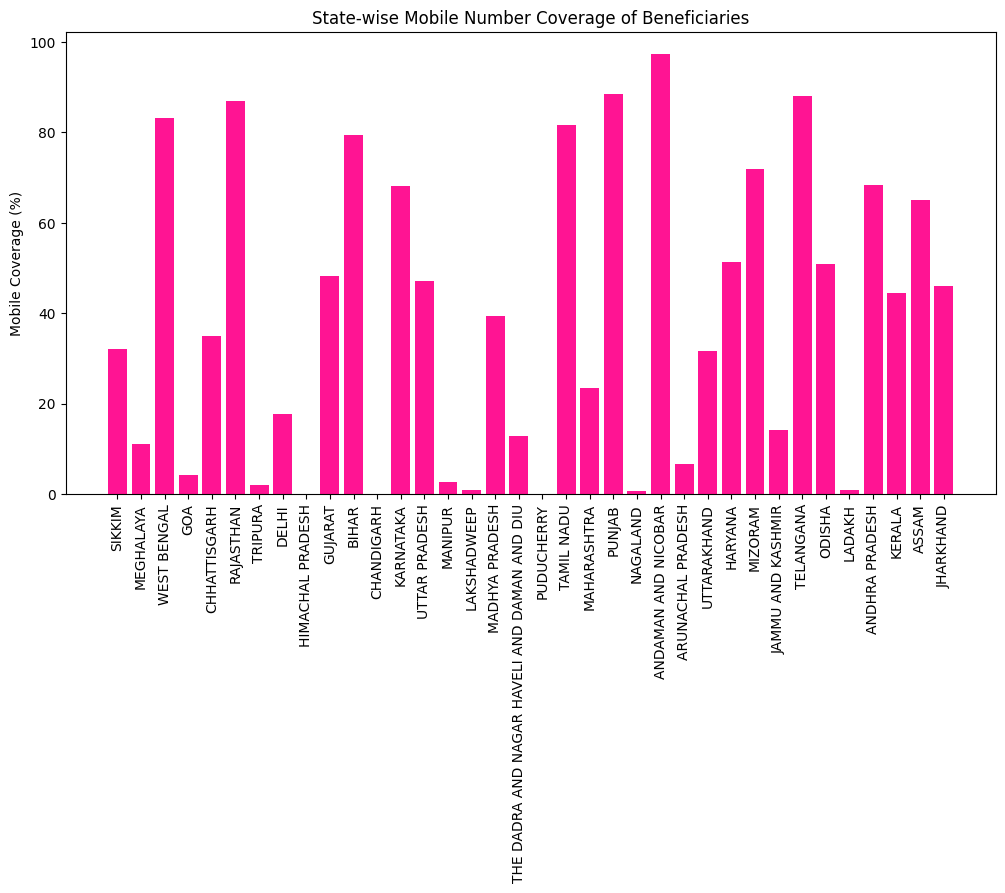

📊 Observation:
- This bar chart compares the count of beneficiaries with mobile numbers across states.
- States with higher mobile coverage are better positioned for SMS/phone-based communication and monitoring.
- Low mobile coverage highlights where alternate outreach channels or mobile-enablement drives are required.


In [14]:
mobile_df = df.groupBy("state_name").sum("total_mobileno", "total_beneficiaries").toPandas()
mobile_df["Mobile_Coverage"] = (mobile_df["sum(total_mobileno)"] / mobile_df["sum(total_beneficiaries)"]) * 100

plt.figure(figsize=(12,6))
plt.bar(mobile_df["state_name"], mobile_df["Mobile_Coverage"], color="DeepPink")
plt.xticks(rotation=90)
plt.ylabel("Mobile Coverage (%)")
plt.title("State-wise Mobile Number Coverage of Beneficiaries")
plt.show()
print("📊 Observation:")
print("- This bar chart compares the count of beneficiaries with mobile numbers across states.")
print("- States with higher mobile coverage are better positioned for SMS/phone-based communication and monitoring.")
print("- Low mobile coverage highlights where alternate outreach channels or mobile-enablement drives are required.")

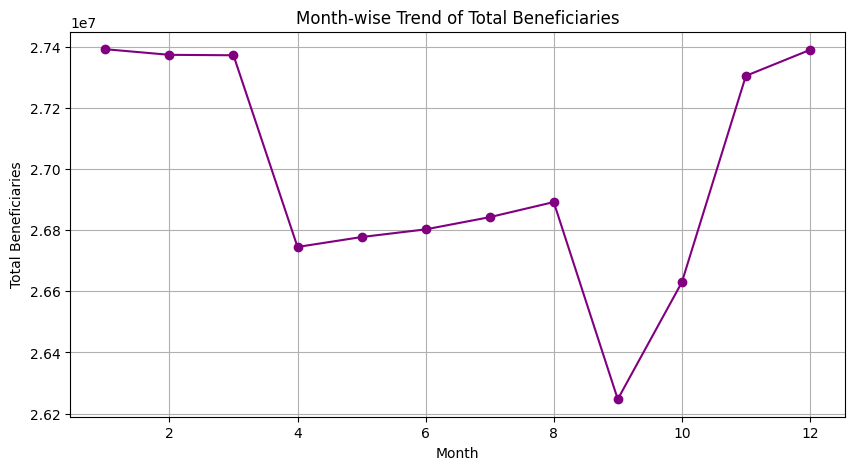

📊 Observation:
- The line chart shows monthly changes in total beneficiaries, useful for spotting trends and seasonality.
- Rising or falling trends indicate growth or contraction in enrolment or disbursement activity over time.
- Sudden spikes/dips should be investigated for program changes, data issues, or campaign effects.


In [15]:
month_df = df.groupBy("mnth").sum("total_beneficiaries").orderBy("mnth").toPandas()

plt.figure(figsize=(10,5))
plt.plot(month_df["mnth"], month_df["sum(total_beneficiaries)"], marker="o", color="purple")
plt.title("Month-wise Trend of Total Beneficiaries")
plt.xlabel("Month")
plt.ylabel("Total Beneficiaries")
plt.grid(True)
plt.show()
print("📊 Observation:")
print("- The line chart shows monthly changes in total beneficiaries, useful for spotting trends and seasonality.")
print("- Rising or falling trends indicate growth or contraction in enrolment or disbursement activity over time.")
print("- Sudden spikes/dips should be investigated for program changes, data issues, or campaign effects.")

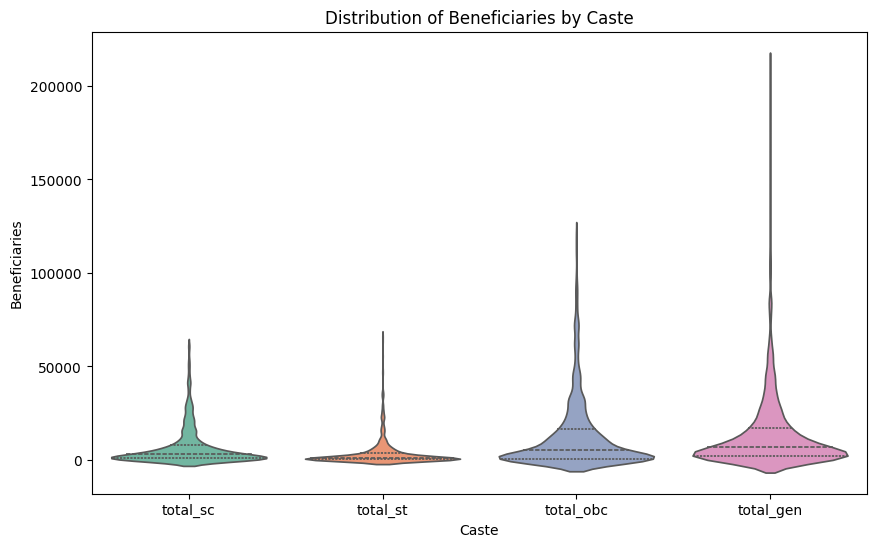

📊 Observation:
- This chart (distribution) shows how beneficiaries are spread across caste categories at the chosen aggregation level.
- It reveals which categories make up the bulk of beneficiaries and which are smaller shares.
- Use this to check whether distribution aligns with policy targets for social inclusion.


In [16]:
violin_df = df.select("total_sc","total_st","total_obc","total_gen").toPandas()
violin_df = violin_df.melt(var_name="Caste", value_name="Beneficiaries")
plt.figure(figsize=(10,6))
sns.violinplot(x="Caste",y="Beneficiaries",data=violin_df,inner="quartile",hue="Caste",palette=sns.color_palette("Set2", 4),dodge=False,legend=False)
plt.title("Distribution of Beneficiaries by Caste")
plt.show()
print("📊 Observation:")
print("- This chart (distribution) shows how beneficiaries are spread across caste categories at the chosen aggregation level.")
print("- It reveals which categories make up the bulk of beneficiaries and which are smaller shares.")
print("- Use this to check whether distribution aligns with policy targets for social inclusion.")

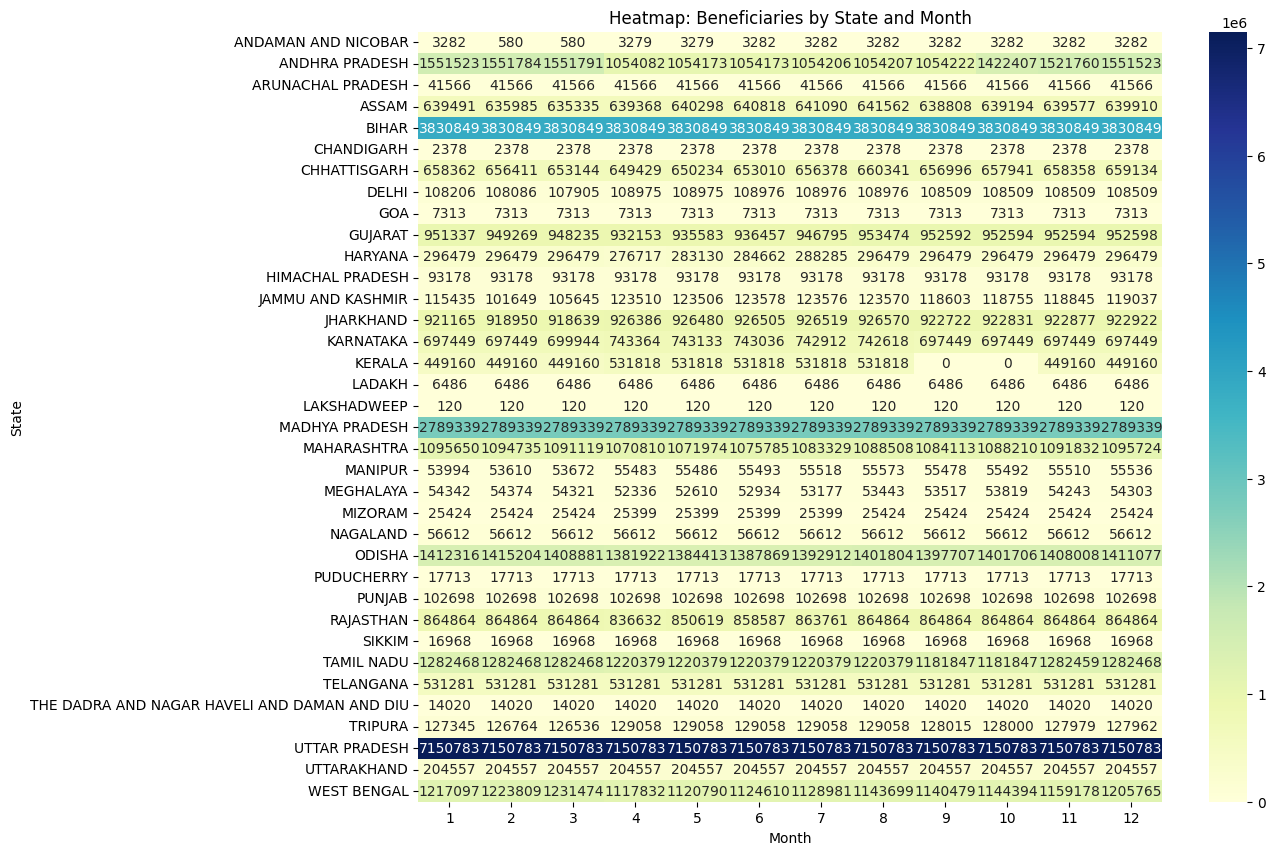

📊 Observation:
- The heatmap displays intensity of beneficiaries over states (rows) and months (columns), highlighting patterns over time and space.
- Stronger (darker) cells indicate months/states with high beneficiary counts; clusters reveal seasonal or regional hotspots.
- This helps detect states with persistent high/low activity and months that consistently peak or dip.


In [17]:
heat_df = df.groupBy("state_name", "mnth").sum("total_beneficiaries").toPandas()
heatmap_data = heat_df.pivot(index="state_name", columns="mnth", values="sum(total_beneficiaries)").fillna(0)

plt.figure(figsize=(12,10))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap: Beneficiaries by State and Month")
plt.xlabel("Month")
plt.ylabel("State")
plt.show()
print("📊 Observation:")
print("- The heatmap displays intensity of beneficiaries over states (rows) and months (columns), highlighting patterns over time and space.")
print("- Stronger (darker) cells indicate months/states with high beneficiary counts; clusters reveal seasonal or regional hotspots.")
print("- This helps detect states with persistent high/low activity and months that consistently peak or dip.")

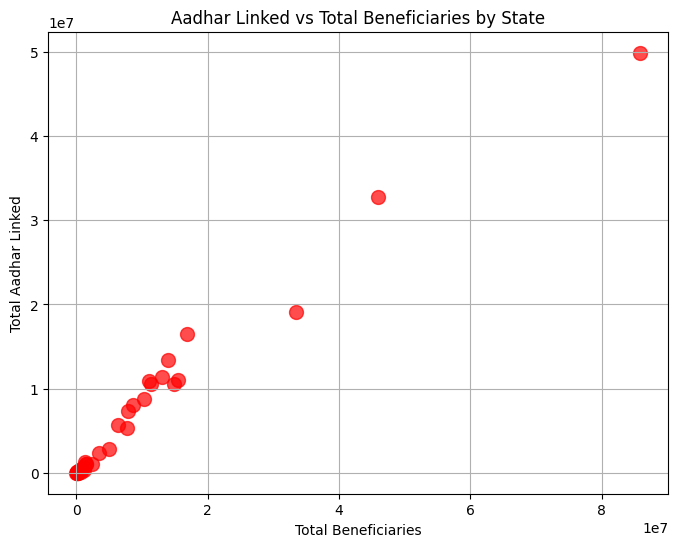

📊 Observation:
- The scatter plot compares Aadhar-linked counts (or coverage) against total beneficiaries for each state.
- Look for correlation: a positive relationship suggests states with more beneficiaries also have better Aadhar linkage.
- Outliers (states with high beneficiaries but low linkage, or vice versa) are worth further investigation.


In [18]:
scatter_df = df.groupBy("state_name").sum("total_aadhar","total_beneficiaries").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(scatter_df["sum(total_beneficiaries)"], scatter_df["sum(total_aadhar)"], color="red", s=100, alpha=0.7)
plt.xlabel("Total Beneficiaries")
plt.ylabel("Total Aadhar Linked")
plt.title("Aadhar Linked vs Total Beneficiaries by State")
plt.grid(True)
plt.show()
print("📊 Observation:")
print("- The scatter plot compares Aadhar-linked counts (or coverage) against total beneficiaries for each state.")
print("- Look for correlation: a positive relationship suggests states with more beneficiaries also have better Aadhar linkage.")
print("- Outliers (states with high beneficiaries but low linkage, or vice versa) are worth further investigation.")

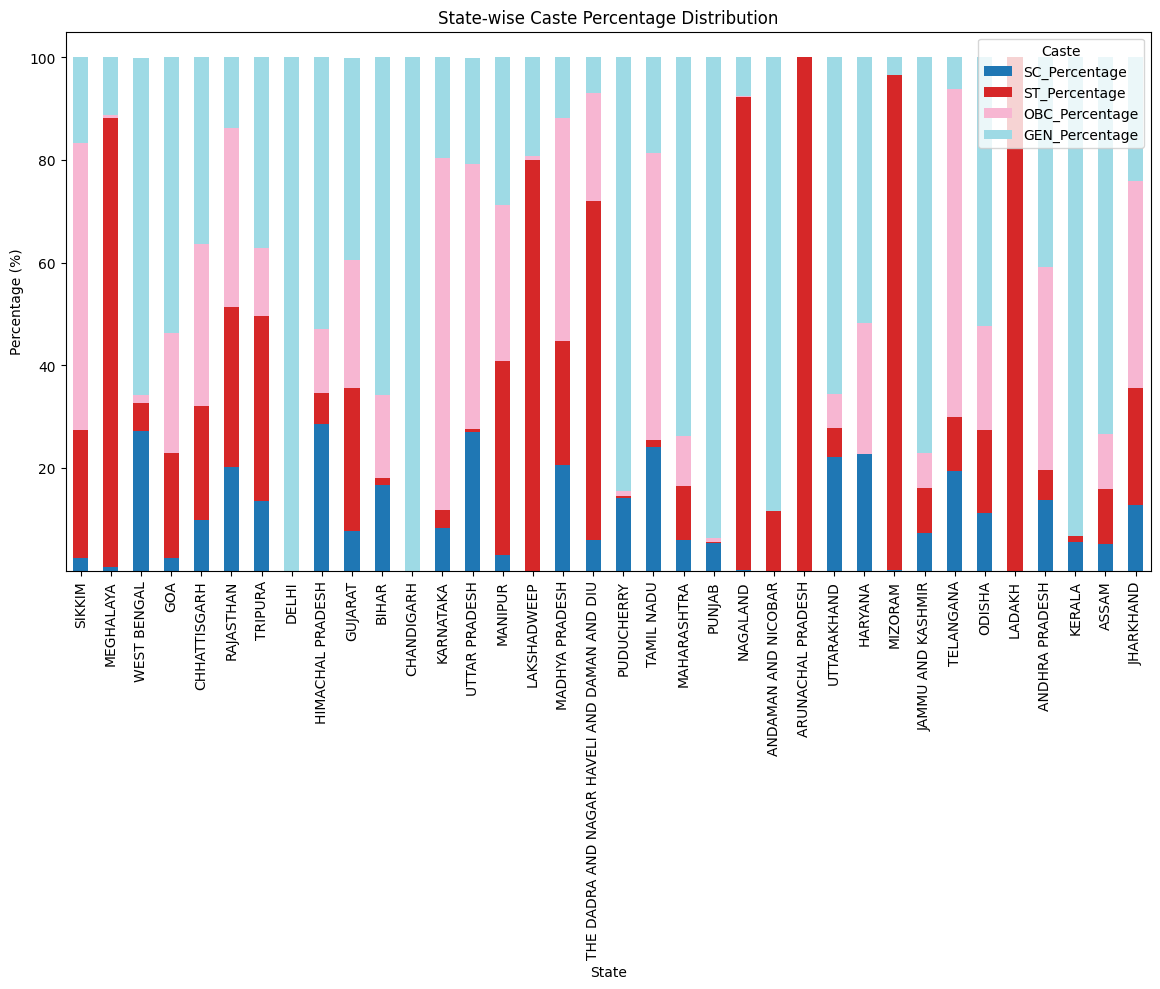

📊 Observation:
- This chart presents caste-wise percentage shares per state, enabling cross-state comparison of caste composition among beneficiaries.
- States with markedly different profiles indicate regional demographic or targeting differences.
- Use these differences to check equity of reach and to tailor state-specific communication or eligibility checks.


In [19]:
per_caste_df = df.groupBy("state_name").sum("total_sc","total_st","total_obc","total_gen","total_beneficiaries").toPandas()
per_caste_df["SC_Percentage"] = (per_caste_df["sum(total_sc)"] / per_caste_df["sum(total_beneficiaries)"])*100
per_caste_df["ST_Percentage"] = (per_caste_df["sum(total_st)"] / per_caste_df["sum(total_beneficiaries)"])*100
per_caste_df["OBC_Percentage"] = (per_caste_df["sum(total_obc)"] / per_caste_df["sum(total_beneficiaries)"])*100
per_caste_df["GEN_Percentage"] = (per_caste_df["sum(total_gen)"] / per_caste_df["sum(total_beneficiaries)"])*100
per_caste_df.set_index("state_name")[["SC_Percentage","ST_Percentage","OBC_Percentage","GEN_Percentage"]].plot(
    kind="bar", stacked=True, figsize=(14,7), colormap="tab20")
plt.title("State-wise Caste Percentage Distribution")
plt.ylabel("Percentage (%)")
plt.xlabel("State")
plt.legend(title="Caste")
plt.show()
print("📊 Observation:")
print("- This chart presents caste-wise percentage shares per state, enabling cross-state comparison of caste composition among beneficiaries.")
print("- States with markedly different profiles indicate regional demographic or targeting differences.")
print("- Use these differences to check equity of reach and to tailor state-specific communication or eligibility checks.")

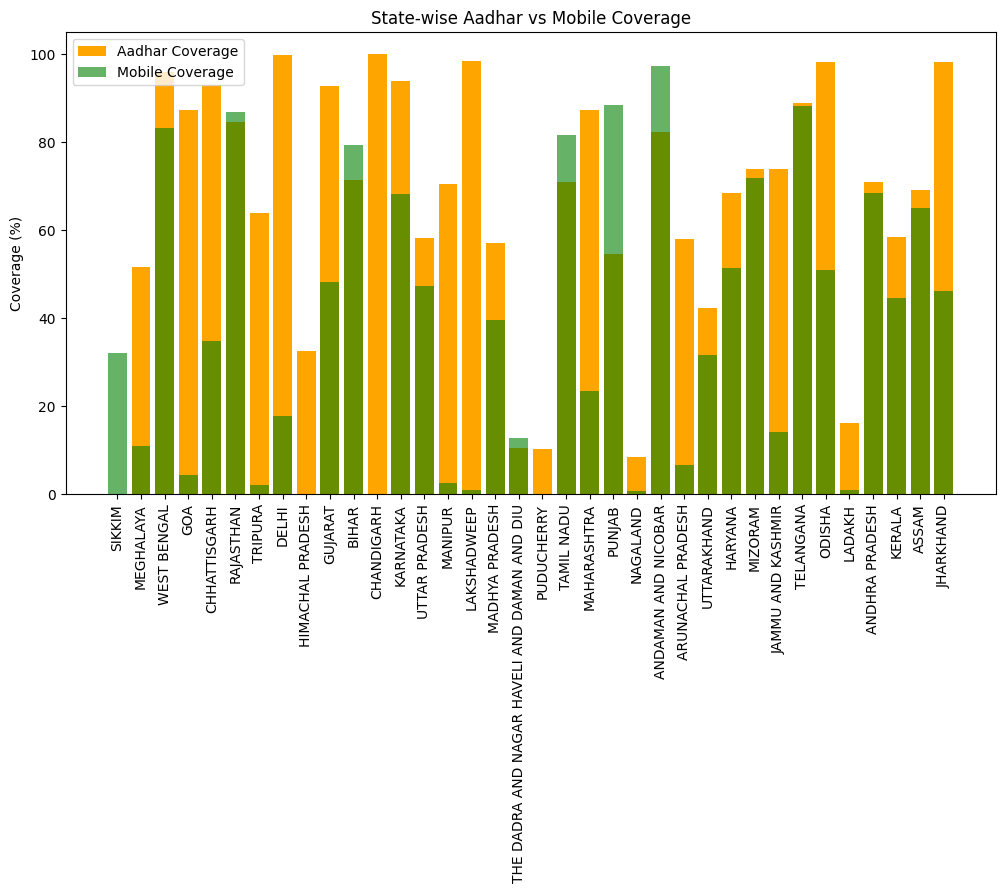

📊 Observation:
- The comparative bar chart contrasts Aadhar coverage and mobile coverage for each state.
- Comparing the two metrics reveals states that are strong on both (better outreach) versus those lagging on one or both.
- Prioritise states where both coverages are low for combined data-improvement and outreach efforts.


In [20]:
coverage_df = df.groupBy("state_name").sum("total_aadhar","total_mobileno","total_beneficiaries").toPandas()
coverage_df["Aadhar_Coverage"] = (coverage_df["sum(total_aadhar)"]/coverage_df["sum(total_beneficiaries)"])*100
coverage_df["Mobile_Coverage"] = (coverage_df["sum(total_mobileno)"]/coverage_df["sum(total_beneficiaries)"])*100

plt.figure(figsize=(12,6))
plt.bar(coverage_df["state_name"], coverage_df["Aadhar_Coverage"], color="orange", label="Aadhar Coverage")
plt.bar(coverage_df["state_name"], coverage_df["Mobile_Coverage"], color="green", alpha=0.6, label="Mobile Coverage")
plt.xticks(rotation=90)
plt.ylabel("Coverage (%)")
plt.title("State-wise Aadhar vs Mobile Coverage")
plt.legend()
plt.show()
print("📊 Observation:")
print("- The comparative bar chart contrasts Aadhar coverage and mobile coverage for each state.")
print("- Comparing the two metrics reveals states that are strong on both (better outreach) versus those lagging on one or both.")
print("- Prioritise states where both coverages are low for combined data-improvement and outreach efforts.")

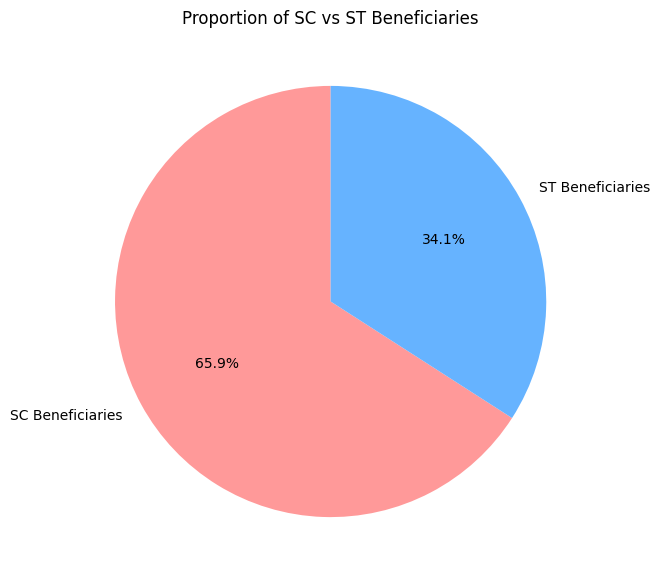

📊 Observation:
- The pie chart compares the relative shares of SC and ST beneficiaries specifically.
- It quickly shows whether one group is substantially larger than the other in the dataset.
- If policy aims target parity or minimum thresholds, this visualization helps assess compliance and gaps.


In [21]:
scatter_df = df.groupBy("state_name").sum("total_sc","total_st").toPandas()
total_sc = scatter_df["sum(total_sc)"].sum()
total_st = scatter_df["sum(total_st)"].sum()

plt.figure(figsize=(7,7))
plt.pie(
    [total_sc, total_st],
    labels=["SC Beneficiaries", "ST Beneficiaries"],
    autopct="%1.1f%%",
    colors=["#ff9999", "#66b3ff"],
    startangle=90)
plt.title("Proportion of SC vs ST Beneficiaries")
plt.show()
print("📊 Observation:")
print("- The pie chart compares the relative shares of SC and ST beneficiaries specifically.")
print("- It quickly shows whether one group is substantially larger than the other in the dataset.")
print("- If policy aims target parity or minimum thresholds, this visualization helps assess compliance and gaps.")

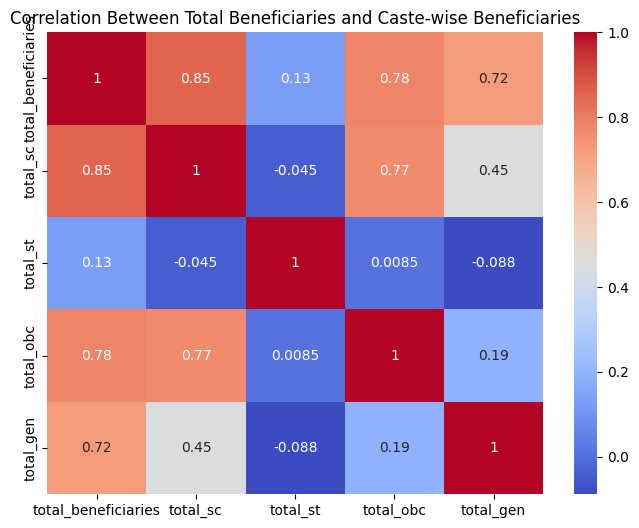

📊 Observation:
- The correlation heatmap shows pairwise correlations between total beneficiaries and caste-wise counts.
- Strong positive correlations indicate that increases in total beneficiaries align with increases in specific caste-group counts; negative/weak correlations point to differing dynamics.
- Use high/low correlations to inform whether aggregate changes are driven by particular social groups.


In [22]:
corr_df = df.select("total_beneficiaries","total_sc","total_st","total_obc","total_gen").toPandas()
corr_matrix = corr_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Total Beneficiaries and Caste-wise Beneficiaries")
plt.show()
print("📊 Observation:")
print("- The correlation heatmap shows pairwise correlations between total beneficiaries and caste-wise counts.")
print("- Strong positive correlations indicate that increases in total beneficiaries align with increases in specific caste-group counts; negative/weak correlations point to differing dynamics.")
print("- Use high/low correlations to inform whether aggregate changes are driven by particular social groups.")

<Figure size 1200x1200 with 0 Axes>

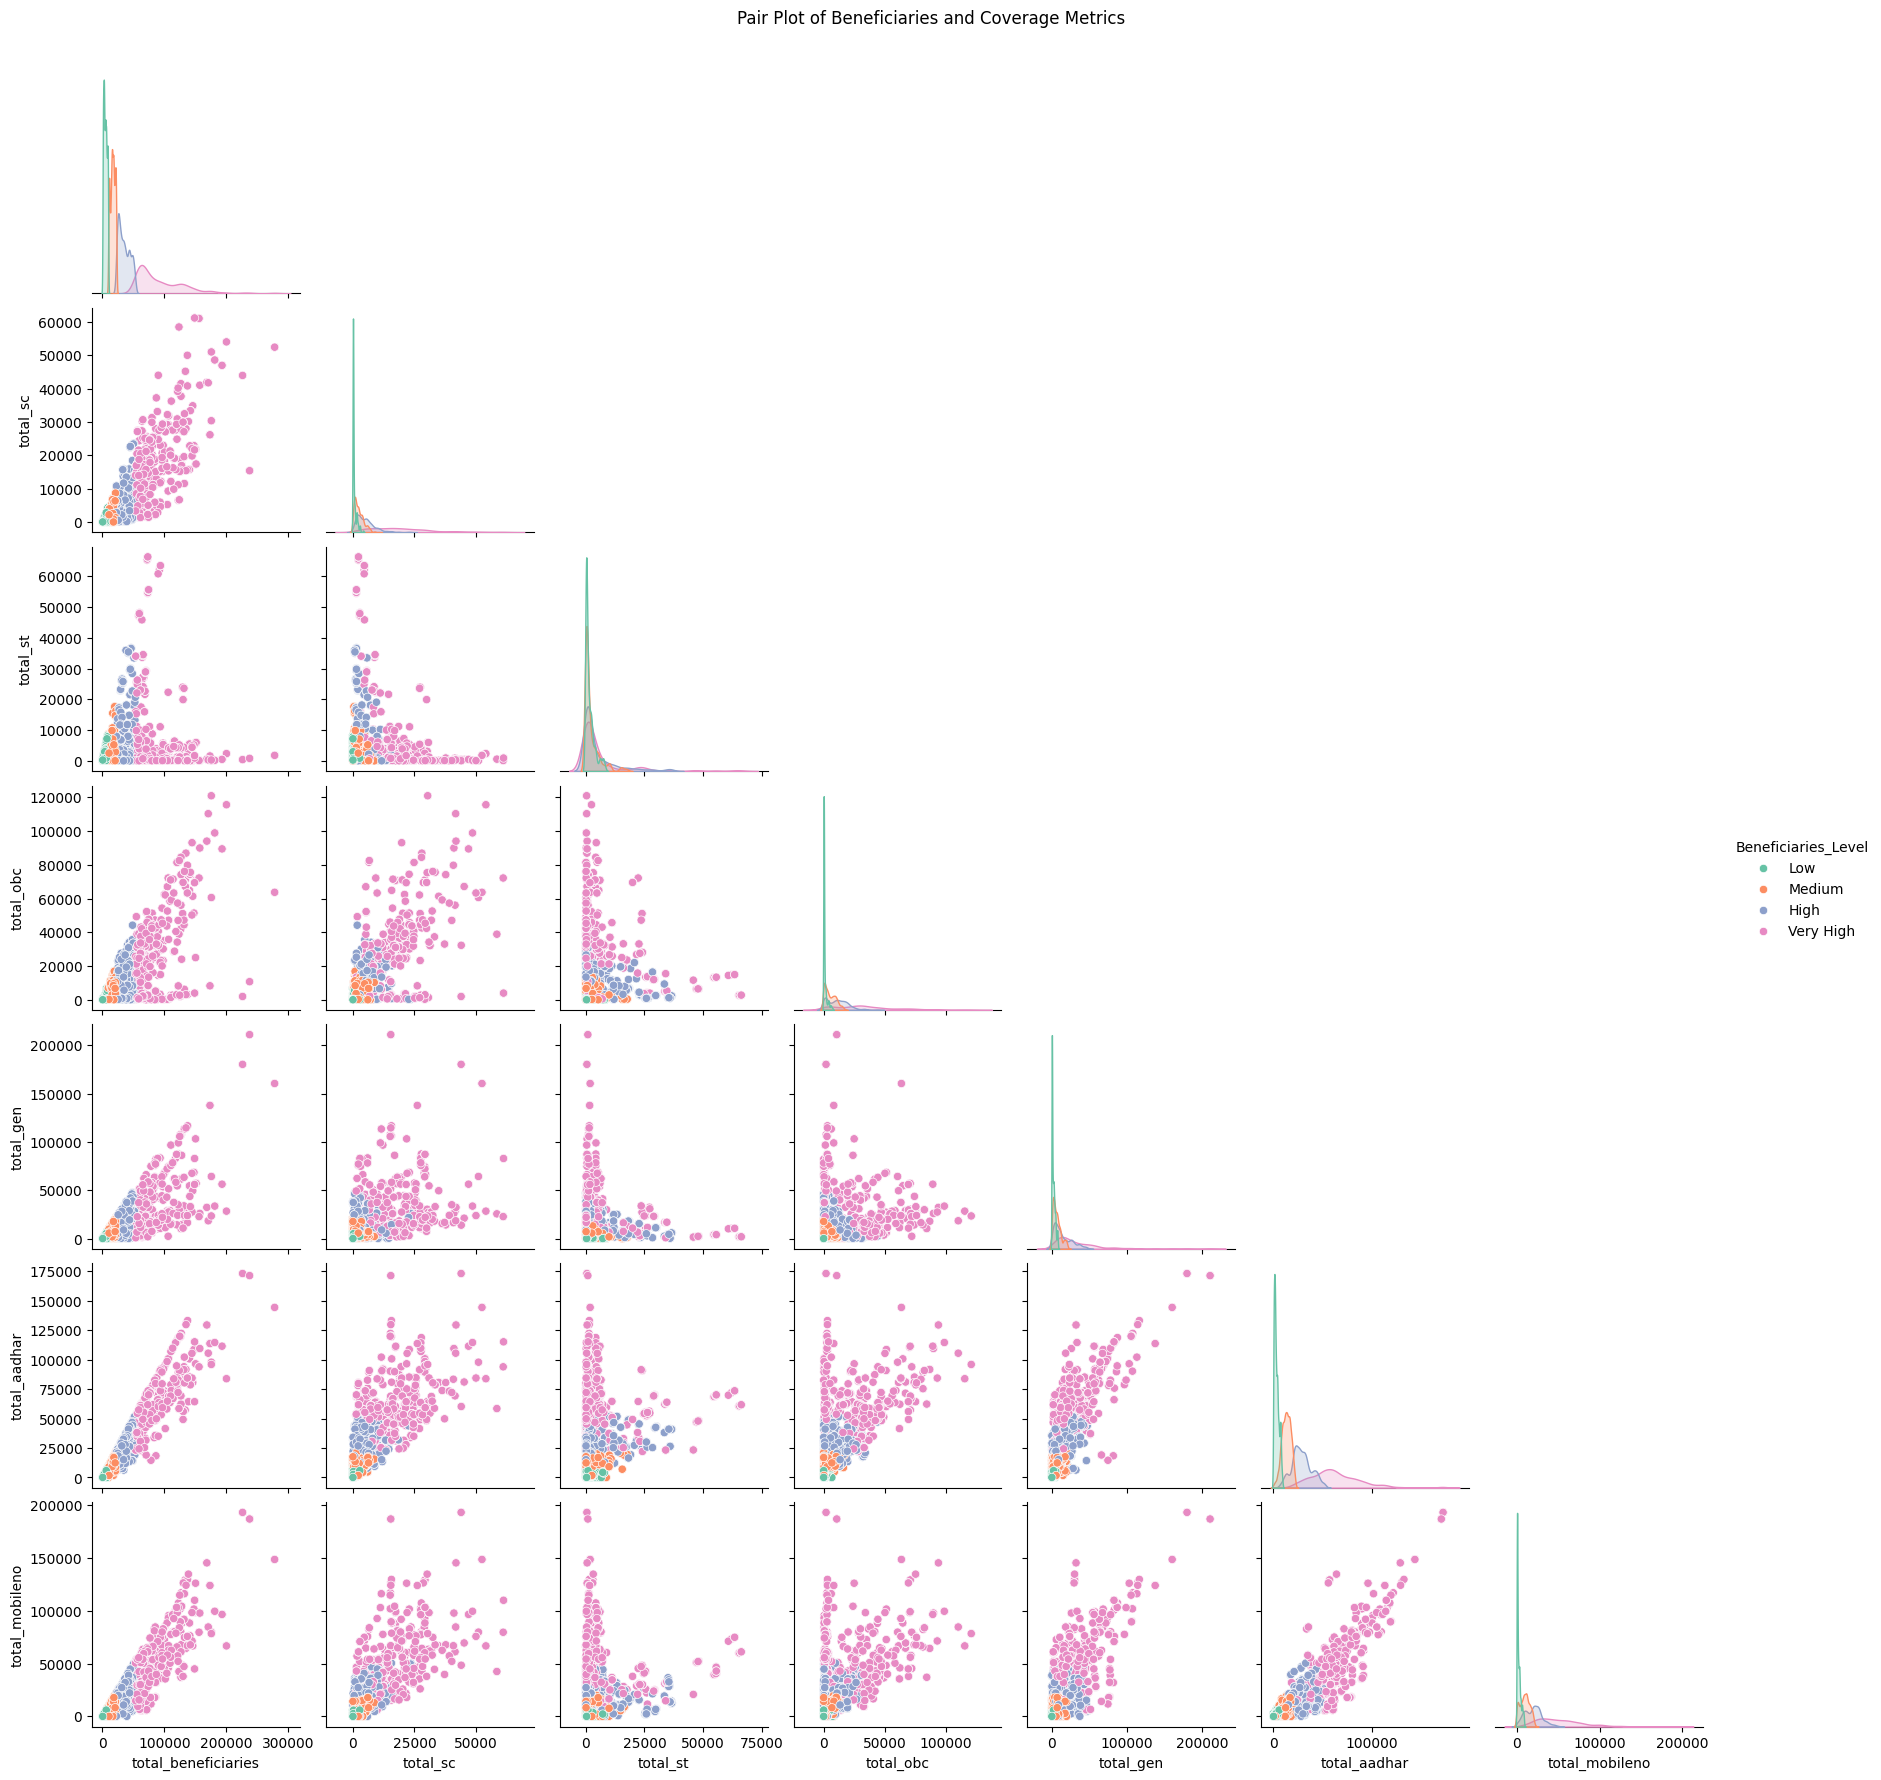

📊 Observation:
- The pair plot shows pairwise relationships among beneficiaries and coverage metrics (e.g., aadhar, mobile) and colours points by beneficiary-level quartiles.
- It helps reveal linear relationships, clusters, and outliers across multiple variable pairs simultaneously.
- Use this to detect which coverage metrics co-vary with beneficiary counts and to spot groups (Low/Medium/High/Very High) that behave differently.


In [23]:
pair_df = df.select("total_beneficiaries","total_sc","total_st","total_obc","total_gen","total_aadhar","total_mobileno").toPandas()
pair_df["Beneficiaries_Level"] = pd.qcut(pair_df["total_beneficiaries"], q=4, labels=["Low","Medium","High","Very High"])
plt.figure(figsize=(12,12))
sns.pairplot(pair_df, hue="Beneficiaries_Level", palette="Set2", corner=True)
plt.suptitle("Pair Plot of Beneficiaries and Coverage Metrics", y=1.02)
plt.show()
print("📊 Observation:")
print("- The pair plot shows pairwise relationships among beneficiaries and coverage metrics (e.g., aadhar, mobile) and colours points by beneficiary-level quartiles.")
print("- It helps reveal linear relationships, clusters, and outliers across multiple variable pairs simultaneously.")
print("- Use this to detect which coverage metrics co-vary with beneficiary counts and to spot groups (Low/Medium/High/Very High) that behave differently.")

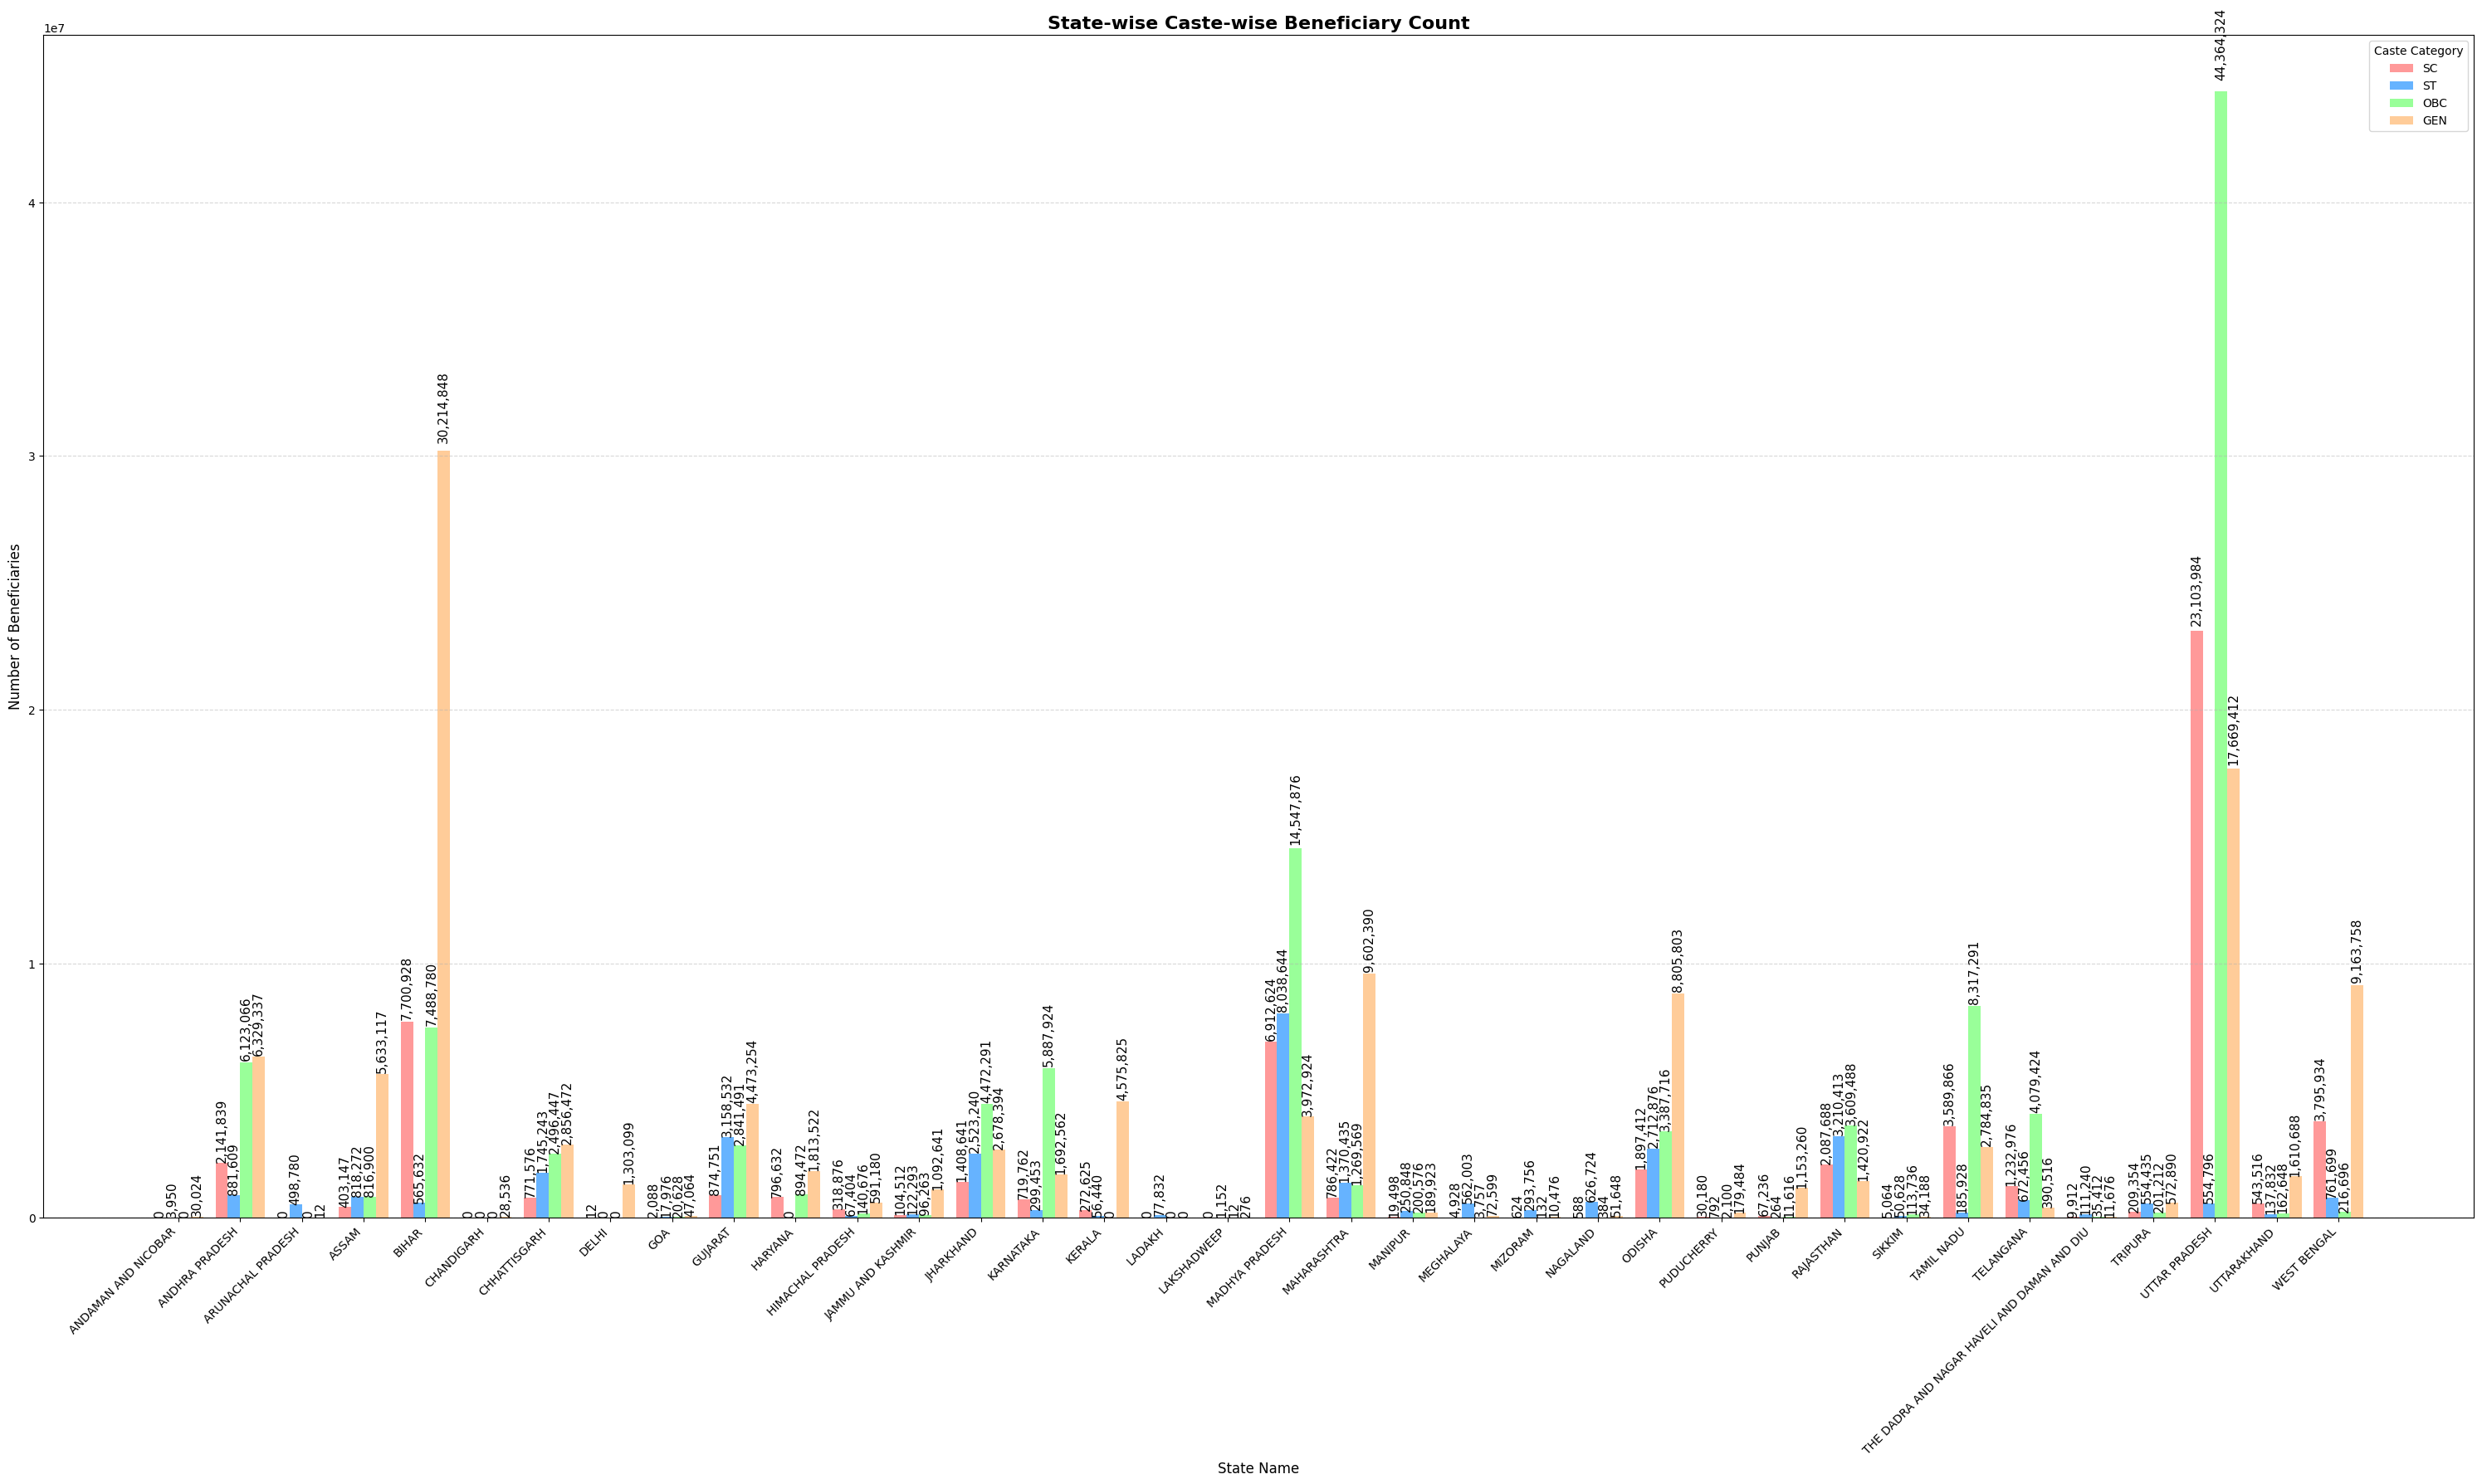

In [24]:
import numpy as np
caste_state_df = df.groupBy("state_name").agg(_sum("total_sc").alias("SC"),_sum("total_st").alias("ST"),_sum("total_obc").alias("OBC"),_sum("total_gen").alias("GEN")).toPandas().sort_values("state_name")
states = caste_state_df["state_name"]
x = np.arange(len(states))
width = 0.20
plt.figure(figsize=(30,18))
bars1 = plt.bar(x - 1.5*width, caste_state_df["SC"], width, label="SC", color="#FF9999")
bars2 = plt.bar(x - 0.5*width, caste_state_df["ST"], width, label="ST", color="#66B3FF")
bars3 = plt.bar(x + 0.5*width, caste_state_df["OBC"], width, label="OBC", color="#99FF99")
bars4 = plt.bar(x + 1.5*width, caste_state_df["GEN"], width, label="GEN", color="#FFCC99")
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,height + (height * 0.01),f"{int(height):,}",ha='center', va='bottom',fontsize=11, rotation=90)
plt.xticks(x, states, rotation=45, ha="right")
plt.title("State-wise Caste-wise Beneficiary Count", fontsize=16, fontweight="bold")
plt.xlabel("State Name", fontsize=12)
plt.ylabel("Number of Beneficiaries", fontsize=12)
plt.legend(title="Caste Category", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [25]:
spark.stop()